In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

In [69]:
df = pd.read_csv('kc_house_data.csv')
print(df.columns)
df.head(10)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,...,7,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,...,7,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113
9,3793500160,3/12/2015,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,...,7,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570


In [ ]:
""""" First step is going to be cleaning up the data a little. Just looking at the head, I can see a couple of issues:
-'Waterfront' appears to have some NaNs. This is a true/false type cat, it should either be true/false or 1/0
    Given the nature of a circumferance/area, it's probably safe to assume that anything
    with a NaN doesn't have a view, but it would be worth seperating neighborhoods/zip codes to see if
    there are missing values clustered in neighborhoods that might have views
-'yr_renovated' has a similar issue, but there are probably some safe strategies to deal with it. If it was originally
    built in the last 10 years, for instance, seems unlikely that it was ever renovated
First, let's go through column by column to see if there are any issues
"""""


In [70]:
df[df['date'].isna()]['date']
#'date' is a string, but there are no blanks, so I'm happy with it for now
df['year'] = list(map(lambda x: int(df['date'][x][-4:]),range(0,len(df))))
df['year'].describe()
#I thought that maybe year sold might end up being an issue, All this data comes from 2014/15 though, so the effect
#is likely small. May return to later though: Is there a noticeable sales price change one year later?

count    21597.000000
mean      2014.322962
std          0.467619
min       2014.000000
25%       2014.000000
50%       2014.000000
75%       2015.000000
max       2015.000000
Name: year, dtype: float64

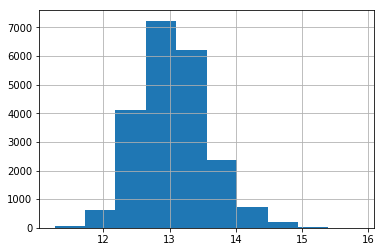

In [71]:
df['price'].describe()
#The spread on 'price' is interesting. The lows and absolute highs are literally of different orders of magnitude
#from the center half of the distribrution. Given the changes in magnitude, house prices might be best 
#analyzed using log(price)
df['log_price'] = np.log(df['price'])
df[['price','log_price']].head()
df['log_price'].hist()
#the log(price) actually looks more like a normal distribution too, how convenient

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64
               id      price  bedrooms  bathrooms  sqft_living
15856  2402100895   640000.0        33       1.75         1620
8748   1773100755   520000.0        11       3.00         3000
13301   627300145  1150000.0        10       5.25         4590
19239  8812401450   660000.0        10       3.00         2920
15147  5566100170   650000.0        10       2.00         3610

average 3 bed price: 708661.8990703851
average 3 bed sqft: 2736.035856573705


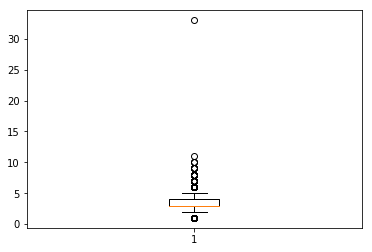

In [72]:
#bedrooms has a weird outlier -- what're the chances that house really does have 33 bedrooms?
print(df['bedrooms'].describe())
plt.boxplot(df['bedrooms'])
print(df.sort_values(by='bedrooms',ascending=False)[['id','price','bedrooms','bathrooms','sqft_living']].head())
# a 33 bed house with 1 and a half baths and 1,620 sq ft? 
#That's funny. This was clearly a 3 bed with a misentered value
print()
print('average 3 bed price: ' +str(df[df['bathrooms']==3]['price'].mean()))
print('average 3 bed sqft: ' +str(df[df['bathrooms']==3]['sqft_living'].mean()))
#Looking a the average price and sq ft of 3 beds makes me believe it, I'm going to change this to a 3 bed
df.at[15856,'bedrooms'] = 3

In [75]:
print(df[df['bedrooms']>7].sort_values(by='bedrooms',ascending=False)
      [['id','price','bedrooms','bathrooms','sqft_living']])
#These other bedroom outliers are a little harder to parse. I'm inclined to believe a house does have 9+ bedrooms
#when it both has lots of bathrooms and a high price tag. I'm inclined to believe there's something fishy
#with the data when the bathrooms/sqft are low. 
# id 13301, a 10 bed, 5 bath, over a million dollars? Maybe
# id 8748, an 11 bed with only 3 bathrooms and 3,000 sqft of living space (~270 sqft/bedroom, 
#not counting kitchen, living room, etc.) seems unlikely.
#for now I'm going to make a list of suspect properties, those with more than 7 beds, but either
#1)fewer than 1/3 as many baths or 2) less than 300 sqft living space per bedroom
df_suspect = df[(df['bedrooms']>7)&((df['sqft_living']<(300*df['bedrooms']))|(df['bathrooms']<df['bedrooms']/3))]
df_suspect

               id      price  bedrooms  bathrooms  sqft_living
8748   1773100755   520000.0        11       3.00         3000
15147  5566100170   650000.0        10       2.00         3610
19239  8812401450   660000.0        10       3.00         2920
13301   627300145  1150000.0        10       5.25         4590
4092   1997200215   599999.0         9       4.50         3830
4231   2902200015   700000.0         9       3.00         3680
6073   9822700190  1280000.0         9       4.50         3650
8537    424049043   450000.0         9       7.50         4050
18428  8823901445   934000.0         9       3.00         2820
16830  8823900290  1400000.0         9       4.00         4620
1658   9126101740   490000.0         8       5.00         2800
18462  1346300150  3300000.0         8       4.00         7710
17221  1338600225  1970000.0         8       3.50         4440
15656  8141200080   680000.0         8       2.75         2530
10946  1652500060  1650000.0         8       2.75      

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,log_price,avg_bed_sqf
8748,1773100755,8/21/2014,520000.0,11,3.0,3000,4960,2.0,0.0,0.0,...,1918,1999.0,98106,47.5560,-122.363,1420,4960,2014,13.161584,272.727273
9068,6746700615,3/18/2015,700000.0,8,2.5,2280,3000,1.5,0.0,0.0,...,1911,0.0,98105,47.6675,-122.316,1610,3000,2015,13.458836,285.000000
15147,5566100170,10/29/2014,650000.0,10,2.0,3610,11914,2.0,0.0,0.0,...,1958,0.0,98006,47.5705,-122.175,2040,11914,2014,13.384728,361.000000
19239,8812401450,12/29/2014,660000.0,10,3.0,2920,3745,2.0,0.0,0.0,...,1913,0.0,98105,47.6635,-122.320,1810,3745,2014,13.399995,292.000000


In [76]:
print(df['bathrooms'].describe())
print(df.sort_values('bathrooms',ascending=False)[['price','bedrooms','bathrooms']].head(10))
#I was at first a little worried about outliers in the baths category, but the high numbered baths are attached to
#houses with lots of beds, so it looks fine
df['sqft_living'].describe()
df.sort_values('sqft_living',ascending=False).head(10)

count    21597.000000
mean         2.115826
std          0.768984
min          0.500000
25%          1.750000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64
           price  bedrooms  bathrooms
12764  2280000.0         7       8.00
7245   7700000.0         6       8.00
9245   6890000.0         6       7.75
8537    450000.0         9       7.50
4020    800000.0         7       6.75
8085   4670000.0         5       6.75
20562  1180000.0         6       6.50
21490  2240000.0         5       6.50
14542  2890000.0         5       6.25
18288  3300000.0         5       6.25


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,log_price,avg_bed_sqf
12764,1225069038,5/5/2014,2280000.0,7,8.00,13540,307752,3.0,0.0,4.0,...,1999,0.0,98053,47.6675,-121.986,4850,217800,2014,14.639686,1934.285714
7245,6762700020,10/13/2014,7700000.0,6,8.00,12050,27600,2.5,0.0,3.0,...,1910,1987.0,98102,47.6298,-122.323,3940,8800,2014,15.856731,2008.333333
3910,9808700762,6/11/2014,7060000.0,5,4.50,10040,37325,2.0,1.0,2.0,...,1940,2001.0,98004,47.6500,-122.214,3930,25449,2014,15.769956,2008.000000
9245,9208900037,9/19/2014,6890000.0,6,7.75,9890,31374,2.0,0.0,4.0,...,2001,0.0,98039,47.6305,-122.240,4540,42730,2014,15.745582,1648.333333
8085,1924059029,6/17/2014,4670000.0,5,6.75,9640,13068,1.0,1.0,4.0,...,1983,2009.0,98040,47.5570,-122.210,3270,10454,2014,15.356670,1928.000000
4407,2470100110,8/4/2014,5570000.0,5,5.75,9200,35069,2.0,0.0,0.0,...,2001,NaN,98039,47.6289,-122.233,3560,24345,2014,15.532906,1840.000000
14542,2303900035,6/11/2014,2890000.0,5,6.25,8670,64033,2.0,0.0,4.0,...,1965,NaN,98177,47.7295,-122.372,4140,81021,2014,14.876767,1734.000000
18288,6072800246,7/2/2014,3300000.0,5,6.25,8020,21738,2.0,0.0,0.0,...,2001,NaN,98006,47.5675,-122.189,4160,18969,2014,15.009433,1604.000000
1162,1247600105,10/20/2014,5110000.0,5,5.25,8010,45517,2.0,1.0,4.0,...,1999,0.0,98033,47.6767,-122.211,3430,26788,2014,15.446710,1602.000000
1446,8907500070,4/13/2015,5350000.0,5,5.00,8000,23985,2.0,0.0,4.0,...,2009,0.0,98004,47.6232,-122.220,4600,21750,2015,15.492607,1600.000000


count    21597.000000
mean       618.170653
std        215.864958
min        163.333333
25%        470.000000
50%        576.666667
75%        722.500000
max       3420.000000
Name: avg_bed_sqf, dtype: float64


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,log_price,avg_bed_sqf
2442,7524900003,12/10/2014,3280000.0,2,1.75,6840,10000,2.5,1.0,4.0,...,2001,0.0,98008,47.6042,-122.112,3120,12300,2014,15.003354,3420.000000
1651,2025079033,12/10/2014,415000.0,1,2.00,3000,204732,2.5,0.0,2.0,...,1979,NaN,98014,47.6331,-121.945,2330,213008,2014,12.936034,3000.000000
13830,8122100355,9/24/2014,550000.0,1,1.00,2880,7560,1.0,0.0,0.0,...,1925,2014.0,98126,47.5370,-122.375,1400,5040,2014,13.217674,2880.000000
7718,3876313030,5/20/2014,458000.0,1,2.25,2140,10350,1.0,0.0,0.0,...,1976,0.0,98072,47.7352,-122.170,1980,8400,2014,13.034624,2140.000000
2123,4379600030,7/29/2014,1330000.0,3,3.75,6400,76665,1.0,0.0,2.0,...,1966,NaN,98177,47.7313,-122.370,3430,60548,2014,14.100690,2133.333333
5577,537000130,9/8/2014,360000.0,1,2.25,2060,10600,1.5,NaN,0.0,...,1927,1983.0,98003,47.3291,-122.304,2060,11880,2014,12.793859,2060.000000
15553,5493110080,8/15/2014,1830000.0,3,3.75,6030,39317,2.0,0.0,0.0,...,1991,0.0,98004,47.6055,-122.210,4040,12333,2014,14.419827,2010.000000
7245,6762700020,10/13/2014,7700000.0,6,8.00,12050,27600,2.5,0.0,3.0,...,1910,1987.0,98102,47.6298,-122.323,3940,8800,2014,15.856731,2008.333333
3910,9808700762,6/11/2014,7060000.0,5,4.50,10040,37325,2.0,1.0,2.0,...,1940,2001.0,98004,47.6500,-122.214,3930,25449,2014,15.769956,2008.000000
14173,7461400360,4/21/2015,299000.0,1,2.50,1980,7521,1.0,0.0,0.0,...,1979,0.0,98055,47.4343,-122.192,1980,8000,2015,12.608199,1980.000000


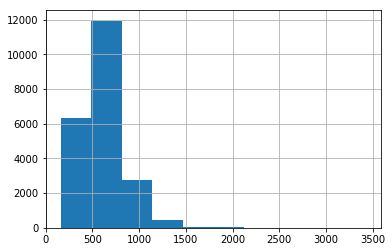

In [74]:
#a more interesting question is how to know if we have unreasonable outliers in the sqft category
#on the one hand, big expensive houses may not only have more bedrooms, but bigger bedrooms. I want to do a
#quick test to see if things look about right. I'll come back to this in more detail in a bit 
df['avg_bed_sqf'] = df['sqft_living']/df['bedrooms']
print(df['avg_bed_sqf'].describe())
df['avg_bed_sqf'].hist()
#looking at average sq ft per room suggests that there are some outliers. On average, 
#you expect maybe 500 sqf per bedroom. Thos top values in the the 3000,s look a little suspect:
#Do they really have rooms that 6 times bigger than average?
df.sort_values('avg_bed_sqf',ascending=False).head(10)
#looking at the head sorted by the average sqft per bed, most of these don't bother me too much, I see a few really
# expensive properties with a bunch of beds, a few on big lots. I want to dig into the top one though, which is an
#enormous 2 bed basically to the edge of the lot

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,log_price,avg_bed_sqf
21560,9253900271,1/7/2015,3570000.0,5,4.50,4850,10584,2.0,1.0,4.0,...,2007,0.0,98008,47.5943,-122.110,3470,18270,2015,15.088076,970.000000
18185,3625059152,12/30/2014,3300000.0,3,3.25,4220,41300,1.0,1.0,4.0,...,1958,1987.0,98008,47.6083,-122.110,3810,30401,2014,15.009433,1406.666667
14070,3625059043,9/4/2014,3300000.0,5,4.75,6200,13873,2.0,1.0,4.0,...,1989,NaN,98008,47.6050,-122.112,2940,13525,2014,15.009433,1240.000000
2442,7524900003,12/10/2014,3280000.0,2,1.75,6840,10000,2.5,1.0,4.0,...,2001,0.0,98008,47.6042,-122.112,3120,12300,2014,15.003354,3420.000000
18440,8043700300,6/8/2014,2700000.0,4,3.25,4420,7850,2.0,1.0,4.0,...,2001,NaN,98008,47.5720,-122.102,2760,8525,2014,14.808762,1105.000000
20751,8043700105,4/17/2015,2300000.0,4,4.00,4360,8175,2.5,1.0,4.0,...,2007,0.0,98008,47.5724,-122.104,2670,8525,2015,14.648420,1090.000000
2138,1224059053,10/27/2014,1700000.0,5,2.00,2500,15250,2.0,1.0,4.0,...,1942,NaN,98008,47.5883,-122.111,1880,18782,2014,14.346139,500.000000
12088,8655000070,6/1/2014,1600000.0,5,3.00,3640,8239,2.0,0.0,3.0,...,1982,0.0,98008,47.5842,-122.111,3330,10643,2014,14.285514,728.000000
5661,9253900417,1/28/2015,1600000.0,3,2.50,2850,19593,1.5,1.0,4.0,...,1978,0.0,98008,47.5894,-122.111,2850,18782,2015,14.285514,950.000000
18899,9253900408,4/8/2015,1400000.0,3,2.75,3130,19530,1.0,1.0,4.0,...,1947,1984.0,98008,47.5895,-122.111,2980,18782,2015,14.151983,1043.333333


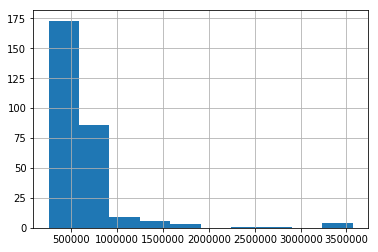

In [77]:
df[df['zipcode']==98008]['price'].hist()
df[df['zipcode']==98008].sort_values('price', ascending=False).head(10)
#Digging into the zipcode, it's a little hard to tell actually. There are some expensive waterfront properties there
#the lots on the water aren't enormous, I'm starting to feel like it might not be an inappropriate outlier at all
#I'm going to leave this in

In [78]:
df.sort_values('sqft_lot',ascending=False).head(10)
#lot 100% needs to be looked at with an eye towards zipcode....

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,log_price,avg_bed_sqf
1717,1020069017,3/27/2015,700000.0,4,1.00,1300,1651359,1.0,0.0,3.0,...,1920,0.0,98022,47.2313,-122.023,2560,425581,2015,13.458836,325.00
17305,3326079016,5/4/2015,190000.0,2,1.00,710,1164794,1.0,0.0,0.0,...,1915,0.0,98014,47.6888,-121.909,1680,16730,2015,12.154779,355.00
7640,2623069031,5/21/2014,542500.0,5,3.25,3010,1074218,1.5,NaN,0.0,...,1931,0.0,98027,47.4564,-122.004,2450,68825,2014,13.203943,602.00
7762,2323089009,1/19/2015,855000.0,4,3.50,4030,1024068,2.0,0.0,0.0,...,2006,0.0,98045,47.4619,-121.744,1830,11700,2015,13.658857,1007.50
3945,722069232,9/5/2014,998000.0,4,3.25,3770,982998,2.0,0.0,0.0,...,1992,0.0,98058,47.4140,-122.087,2290,37141,2014,13.813509,942.50
4437,3626079040,7/30/2014,790000.0,2,3.00,2560,982278,1.0,0.0,0.0,...,2004,0.0,98014,47.6955,-121.861,1620,40946,2014,13.579788,1280.00
6685,2624089007,3/20/2015,2000000.0,2,2.50,3900,920423,2.0,0.0,0.0,...,2009,0.0,98065,47.5371,-121.756,2720,411962,2015,14.508658,1950.00
7070,2724079090,1/5/2015,1650000.0,4,3.25,3920,881654,3.0,NaN,3.0,...,2002,NaN,98024,47.5385,-121.896,2970,112384,2015,14.316286,980.00
9705,225079036,1/7/2015,937500.0,4,4.00,5545,871200,2.0,0.0,0.0,...,2003,0.0,98014,47.6760,-121.882,3420,871200,2015,13.750972,1386.25
20436,1125079111,4/15/2015,1600000.0,4,5.50,6530,871200,2.0,0.0,2.0,...,2008,0.0,98014,47.6640,-121.878,1280,858132,2015,14.285514,1632.50


In [79]:
#let's create a data frame of average stats by zipcode
zip_df = pd.DataFrame(index=list(set(df['zipcode'])))
zip_df['avg_price']=list(map(lambda x:df[df['zipcode']==x]['price'].mean(),list(zip_df.index)))
zip_df['avg_sqft'] = list(map(lambda x:df[df['zipcode']==x]['sqft_living'].mean(),list(zip_df.index)))
zip_df['avg_plot'] = list(map(lambda x:df[df['zipcode']==x]['sqft_lot'].mean(),list(zip_df.index)))
zip_df['plot_std'] = list(map(lambda x:df[df['zipcode']==x]['sqft_lot'].std(),list(zip_df.index)))

zip_df.describe()

,avg_price,avg_sqft,avg_plot,plot_std
count,7.000000e+01,70.000000,70.000000,70.000000
mean,5.610109e+05,2098.819704,18321.192039,26198.112394
std,3.023940e+05,434.646434,21855.640503,39260.848859
min,2.342840e+05,1468.624535,3194.368421,1692.662740
25%,3.541339e+05,1784.765800,6260.391166,3767.390243
50%,4.920012e+05,2033.363414,10564.537500,8218.400497
75%,6.455322e+05,2313.551402,17337.001169,23770.801927
max,2.161300e+06,3800.900000,102735.437500,183845.531590


In [17]:
zip_df.loc[98022]
#Now we see that the 98022 area code actually has really big lots (google maps suggests that part of the 
#area code is sort of rural). so maybe that house sitting on a 1.5 million sq feet lot isn't actually so weird...
#That's around 30 acres, it's a big plot, but maybe not absurd out in the country
#In the interest of thorough checking, I looked up the lat/long in google maps, and am comfortable that the farm-type
#house on that lot is indeed on about 1.5M sqft of land.

avg_price    316742.390558
avg_sqft       1837.313305
avg_plot      74233.914163
plot_std     160272.653860
Name: 98022, dtype: float64

medium density    25
dense - urban     18
low density       14
rural             13
Name: density, dtype: int64

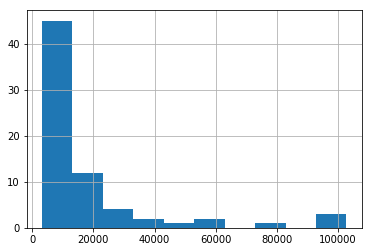

In [80]:
zip_df['avg_plot'].hist()
zip_df.sort_values('avg_plot',ascending=False).head(10)
#let's introduce a category for sort of area, trying to categorize whether the house is in a more 
#urban, or more rural area. we'll use the avg plot size per zipcode as a first pass
#Bins - less than 6K sq ft a plot, dense urban
# - less than 12K sq ft medium dense
# - less than 25K low dense
#above - rural
zip_df['density'] = ['dense - urban' if n <6000 else 'medium density' if n<12000 else 
                     'low density' if n <25000 else 'rural' for n in zip_df['avg_plot']]
zip_df['density'].value_counts()
#maybe later we'll try to build a better one later--
#EDIT - Damnit, this was already built into the data set! The nearest 15 neighbors plot - sqft. I'll use that instead

In [81]:
df['sqft_lot15'].describe()
df['density'] = ['dense - urban' if n <4000 else 'medium density' if n<8000 else 
                     'low density' if n <50000 else 'rural' for n in df['sqft_lot15']]
df['density'].value_counts()


medium density    9237
low density       9059
dense - urban     2620
rural              681
Name: density, dtype: int64

In [82]:
#clearing out the NaN in the waterfront pointer
print(df['waterfront'].isna().sum())
df['waterfront'] = df['waterfront'].fillna(0)
df['waterfront'].isna().sum()

2376


0

In [83]:
#Give the amount of missing data in the yr_renovated category, coupled with the likelihood that most of the 
#ones without a proper number probably simply have never actually undergone a reno, I'm going to turn this into
#a dummy, on the assumption that missing data probably means there hasn't been a reno recently and also
#on the assumption that if a renovation hasn't been done reently it's not likely to matter in any meaningful way
#Let's sub in a flag for 'renovated in the last ten years'
df['reno_flag'] = list(map(lambda x: 1 if x>2005 else 0, df['yr_renovated']))
df[df['yr_renovated']>0][['yr_renovated','reno_flag']].head(10)
df['reno_flag'].sum()
#A pretty small subset here, but possibly will have a noticeable effect

236

In [84]:
#Zipcode is clearly really important as way to split out all houses, this is a categorical variable
#unfortunately this means making a lot of dummies.... there are 70 zip codes in the data set
zip_dummies = pd.get_dummies(df['zipcode'], prefix='zip')
df = pd.concat([df, zip_dummies], axis=1)
df.head()
#I need to drop one of these dummies... I'm going to drop the first one to show up, 98001, which appears to 
#be a relatively low price zipcode, which will aid interpretability
df.drop('zip_98001', axis=1, inplace=True)
df.head()
#Given the number of zipcodes, this is maybe a case where a multi-level model would be most appropriate
#For now, I don't know exactly how to make that in python...

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
#gonna make a 2015 flag, on the off chance that year to year there's a significant difference
df['flag_2015'] = list(map(lambda x: 1 if x==2015 else 0, df['year']))
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,2015_flag,flag_2015
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1


In [212]:
#Building condition and grade present some interesting questions. They're likely to be highly correlated given
#their descriptions, I would only consider having one of them in the model at any one time. They're also
#sort of categorical, but currently formatted as convenient number scales, to the extent you think that moving
#one rung up the ladder of condition has about the same effect on the final sales price regardless of which
#rung you started on, you might keeping it in 'numerical' form rather than creating 12 dummy variables to
#correspond to each of the categories. I'll make the dummies and see what that does to the model.
grade_dummies = pd.get_dummies(df['grade'],prefix='grade')
grade_dummies.drop('grade_3',axis=1,inplace=True)
df = pd.concat([df,grade_dummies],axis=1)
#Most of the grade dummmies are not significant, and the effects between the lower values which are significant
# are about the same. This whole category might be replaced by a single dummy which is 'grade <6'

In [220]:
df['grade_dummy'] = list(map(lambda x: 1 if x>5 else 0,df['grade']))
#this doesn't seem to work as well as just keeping 'grade' a 'numerical' variable!

In [334]:
variables = ['sqft_living','bedrooms','flag_2015','reno_flag','waterfront','grade']

formula = 'log_price~'+'+'.join(variables)
model = ols(formula = formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     4744.
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        15:53:45   Log-Likelihood:                -7712.1
No. Observations:               21597   AIC:                         1.544e+04
Df Residuals:                   21590   BIC:                         1.549e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      11.2202      0.021    533.014      0.000      11.179      11.261
sqft_living     0.0002   4.67e-06     48.089      0.000       0.000       0.000
bedrooms       -0.0186      0.003     -5.658      0.000      -0.025      -0.012
flag_2015       0.0333      0.005      6.616      0.000       0.023       0.043
reno_flag       0.2542      0.023     11.221      0.000       0.210       0.299
waterfront      0.6159      0.029     21.256      0.000       0.559       0.673
grade           0.1836      0.003     58.352      0.000       0.177       0.190
==============================================================================
Omnibus:                       31.958   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.204
Skew:                           0.067   Prob(JB):                     2.76e-07
Kurtosis:                       2.875   Cond. No.                     2.80e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [221]:
variables = ['bedrooms','bathrooms','sqft_living','flag_2015','reno_flag','waterfront','grade']+list(zip_dummies.columns)[1:]
#+list(zip_dummies.columns)[1:]
formula = 'log_price~'+'+'.join(variables)
model = ols(formula = formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     1478.
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        10:22:54   Log-Likelihood:                 2945.5
No. Observations:               21597   AIC:                            -5737.
Df Residuals:                   21520   BIC:                            -5122.
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      11.6810      0.018    665.965      0.000      11.647      11.715
bedrooms       -0.0233      0.002    -11.356      0.000      -0.027      -0.019
bathrooms       0.0393      0.003     13.258      0.000       0.034       0.045
sqft_living     0.0003   2.71e-06    119.616      0.000       0.000       0.000
flag_2015       0.0498      0.003     16.121      0.000       0.044       0.056
reno_flag       0.0913      0.014      6.557      0.000       0.064       0.119
waterfront      0.6736      0.018     37.265      0.000       0.638       0.709
grade_dummy     0.1831      0.013     13.797      0.000       0.157       0.209
zip_98002      -0.0541      0.019     -2.894      0.004      -0.091      -0.017
zip_98003       0.0314      0.017      1.865      0.062      -0.002       0.064
zip_98004       1.1718      0.016     71.533      0.000       1.140       1.204
zip_98005       0.8142      0.020     41.127      0.000       0.775       0.853
zip_98006       0.7300      0.015     49.578      0.000       0.701       0.759
zip_98007       0.7049      0.021     33.539      0.000       0.664       0.746
zip_98008       0.6898      0.017     41.020      0.000       0.657       0.723
zip_98010       0.2842      0.024     11.884      0.000       0.237       0.331
zip_98011       0.4601      0.019     24.462      0.000       0.423       0.497
zip_98014       0.3408      0.022     15.446      0.000       0.298       0.384
zip_98019       0.3193      0.019     16.833      0.000       0.282       0.357
zip_98022       0.1295      0.018      7.286      0.000       0.095       0.164
zip_98023      -0.0172      0.015     -1.174      0.240      -0.046       0.011
zip_98024       0.4755      0.026     18.176      0.000       0.424       0.527
zip_98027       0.5435      0.015     35.532      0.000       0.513       0.573
zip_98028       0.4260      0.017     25.361      0.000       0.393       0.459
zip_98029       0.6393      0.016     39.271      0.000       0.607       0.671
zip_98030       0.0474      0.017      2.743      0.006       0.014       0.081
zip_98031       0.0767      0.017      4.520      0.000       0.043       0.110
zip_98032      -0.0240      0.022     -1.092      0.275      -0.067       0.019
zip_98033       0.8202      0.015     54.287      0.000       0.791       0.850
zip_98034       0.5484      0.014     38.197      0.000       0.520       0.577
zip_98038       0.1706      0.014     12.048      0.000       0.143       0.198
zip_98039       1.3159      0.032     40.995      0.000       1.253       1.379
zip_98040       0.9762      0.017     57.600      0.000       0.943       1.009
zip_98042       0.0708      0.014      4.935      0.000       0.043       0.099
zip_98045       0.3647      0.018     20.151      0.000       0.329       0.400
zip_98052       0.6799      0.014     47.76

In [64]:
#sample=['variable']+list(zip_dummies.columns)[1:]
#sample
print(len(list(zip_dummies.columns)[1:]))
print(len(set(list(zip_dummies.columns)[1:])))

69
69


In [183]:
#Here I'll add the zip code qualifiers to the main dataframe on a house by house basis
df['zip_density'] = list(map(lambda x: zip_df.loc[df.loc[x]['zipcode']]['density'],range(0,len(df))))

df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price,avg_bed_sqf,year,zip_density
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,0.0,98178,47.5112,-122.257,1340,5650,12.309982,393.333333,2014,medium density
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,1991.0,98125,47.7210,-122.319,1690,7639,13.195614,856.666667,2014,medium density
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,NaN,98028,47.7379,-122.233,2720,8062,12.100712,385.000000,2015,medium density
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,0.0,98136,47.5208,-122.393,1360,5000,13.311329,490.000000,2014,dense - urban
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,0.0,98074,47.6168,-122.045,1800,7503,13.142166,560.000000,2015,low density


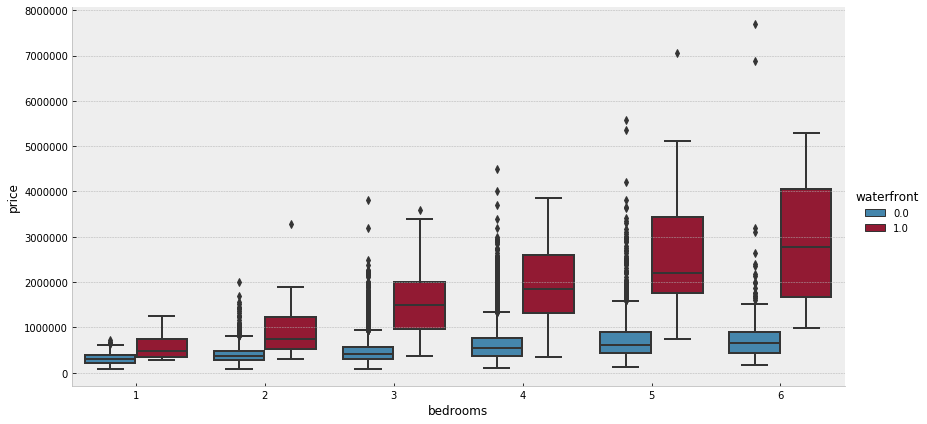

In [327]:
#Time to make some charts
import matplotlib.style as style
style.use('bmh')
import matplotlib.ticker as ticker #There must be another way that doesn't use this in particular


ax = sns.catplot(x='bedrooms',y='price',hue='waterfront',data=df[df['bedrooms']<7], kind='box', height=6, aspect=2)
#ax.yaxis.set_major_formatter(ticker.EngFormatter())



/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



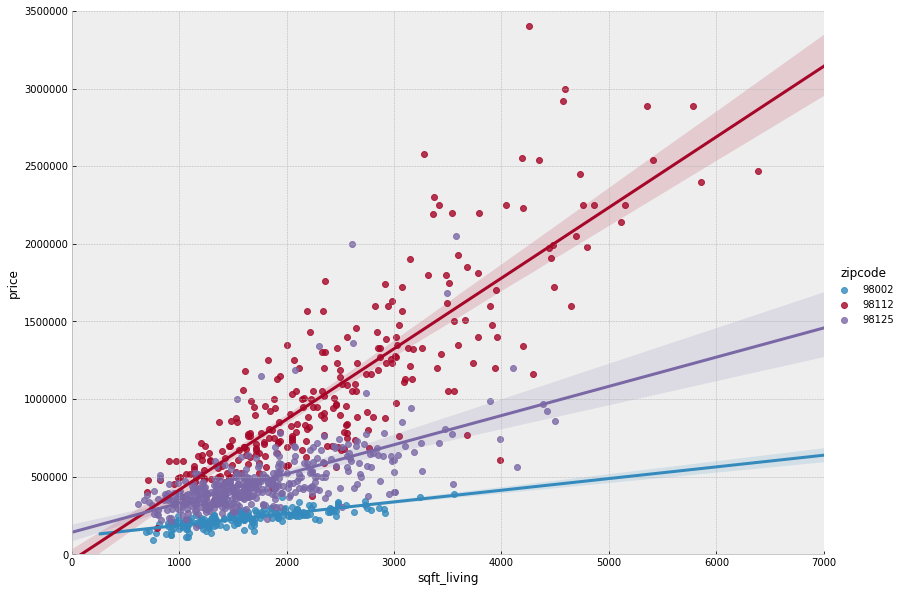

In [167]:
samplezips = [98112,98125,98002]
plt1 = sns.lmplot(x='sqft_living', y='price',hue='zipcode', data = df[df['zipcode'].isin(samplezips)],
                  height=8.27, aspect=11.7/8.27)
plt1.set(xlim=(0,7000), ylim=(0,3500000))

#df[df['zipcode'].isin(samplezips)]
#plt1.yaxis.set_major_formatter(ticker.EngFormatter())

In [224]:
df.loc[1]['zipcode'] in samplezips

True

In [267]:
df.groupby('zipcode').count().sort_values(by='id',ascending=False).head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,year,log_price,avg_bed_sqf,density
zipcode,,,,,,,,,,,,,,,,,,,,,
98103,602,602,602,602,602,602,602,602,602,601,...,602,480,602,602,602,602,602,602,602,602
98038,589,589,589,589,589,589,589,589,589,586,...,589,493,589,589,589,589,589,589,589,589
98115,583,583,583,583,583,583,583,583,583,580,...,583,464,583,583,583,583,583,583,583,583
98052,574,574,574,574,574,574,574,574,574,573,...,574,467,574,574,574,574,574,574,574,574
98117,553,553,553,553,553,553,553,553,553,553,...,553,451,553,553,553,553,553,553,553,553


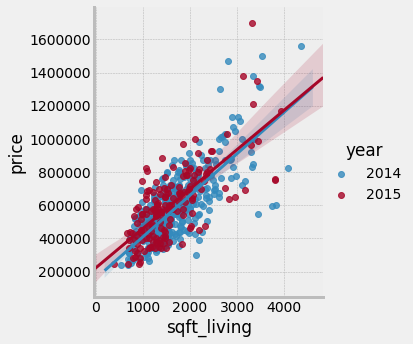

In [273]:
#Does it look graphically like there is much change in price from year to year? Overall, not really
#but results vary based on zipcode, will come back tot this and categorize zipcodes based on whether prices seem
#to be rising or falling.
plt = sns.lmplot(x='sqft_living', y='price', hue='year', data=df[df['zipcode']==98103])

In [135]:


data = [dict(type='scattergeo',locationmode='USA-states', lon=df['long'],
            lat = df['lat'], marker = dict(size = 4, 
                                           colorscale = 'Jet',
                                          color = df['log_price'],
                                          colorbar = dict(title='Price')))]
layout = dict(title='Price test',
             geo = dict(scope='usa', projection = dict(type='albers usa'),countrywidth=0.5))
fig = go.Figure(data=data, layout=layout)
plotly.offline.plot(fig, validate=False)

'temp-plot.html'

In [169]:
df['color_marker'] = pd.cut(df['log_price'], bins = 7, 
                            labels=['blue','purple','green','yellow','orange','red','bright red'])
#df.head()

In [317]:
import folium
kings_map = folium.Map(location=[47.57136,-122.167178], zoom_start=11)
for n in range(0,len(df)):
    marker = folium.CircleMarker(location = [df.loc[n]['lat'],df.loc[n]['long']],
                                 color = df.loc[n]['color_marker'],radius=.5)
    marker.add_to(kings_map)


kings_map.save('map.html')

In [191]:
#Here let's try to disentangle the effect of the year on the sales price. Effect on the overall population is
#positive, meaning prices did rise, but not enormous. Are some neighborhoods seeing greater rise in house prices
#than others? Here I iterate over every zipcode, making a smaller regression model with bedrooms, baths, 
#my renovated flag, the grade and my flag for a 2015 sale, which essentially marks the model's estimate for
#how much home prices have risen over the year. I pull out all these estimates to make a list of estimates by
#zipcode
from sklearn.linear_model import LinearRegression
zip_df['price_growth']=np.nan
for code in set(list(df['zipcode'])):
    linreg=LinearRegression()
    linreg.fit(df[df['zipcode']==code][['bedrooms','bathrooms','reno_flag','grade','flag_2015']],
               df[df['zipcode']==code]['log_price'])
    zip_df.at[code,'price_growth'] = linreg.coef_[-1]
zip_df['price_growth']

98177    0.043707
98178    0.025994
98052    0.048955
98053    0.032575
98055    0.060475
98056    0.039109
98058    0.021682
98059    0.029546
98188    0.032785
98065    0.036452
98198    0.013312
98070    0.017530
98199    0.010768
98072    0.025284
98074    0.032911
98075    0.038805
98077    0.034203
98092    0.009165
98102    0.058947
98103    0.060077
98105    0.035668
98106    0.052365
98107    0.086057
98108    0.049774
98109    0.023732
98112    0.102827
98115    0.084023
98116    0.041574
98117    0.070636
98118    0.063154
           ...   
98005    0.049539
98007    0.036601
98136    0.075099
98008    0.044744
98010   -0.009658
98168    0.080258
98006    0.045602
98011    0.054875
98014   -0.005031
98144    0.024915
98146    0.089309
98019    0.070738
98148    0.095399
98022    0.007121
98023    0.039865
98024    0.006018
98027    0.039833
98028    0.015973
98029    0.051514
98030    0.017560
98155    0.037146
98032    0.013105
98033    0.122682
98034    0.058318
98031    0

In [193]:
zip_df.sort_values('price_growth').tail()

,avg_price,avg_sqft,avg_plot,plot_std,density,price_growth
98146,3.594963e+05,1621.451389,9020.243056,5476.910267,medium density,0.089309
98148,2.849086e+05,1610.526316,8960.719298,2735.295791,medium density,0.095399
98112,1.096239e+06,2498.743494,4990.431227,3129.238251,dense - urban,0.102827
98004,1.356524e+06,2909.022082,13104.220820,6441.120122,low density,0.105718
98033,8.039908e+05,2381.340278,10493.812500,7916.056192,medium density,0.122682


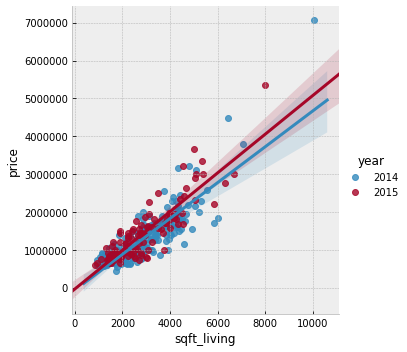

In [198]:
plt = sns.lmplot(x='sqft_living', y='price', hue='year', data=df[df['zipcode']==98004])

In [226]:
#Going to make estimations with a naive model, one that doesn't have the zip code flags
#Then we'll plot out the errors relative to the model estimate! Like the price heatmap but controled for size, etc.
pred_df = pd.DataFrame()
pred_df['bedrooms']= df['bedrooms']
pred_df['bathrooms']=df['bathrooms']
pred_df['reno_flag']= df['reno_flag']
pred_df['grade'] = df['grade']
pred_df['log_price'] = df['log_price']
pred_df['lat'] = df['lat']
pred_df['long'] = df['long']
pred_df['sqft_living'] = df['sqft_living']

linreg=LinearRegression()
linreg.fit(pred_df[['sqft_living','bedrooms','bathrooms','reno_flag','grade']],pred_df['log_price'])
pred = linreg.predict(pred_df[['bedrooms','bedrooms','bathrooms','reno_flag','grade']])
pred_df['pred'] = list(pred)
pred_df['diff'] = pred_df['log_price'] - pred_df['pred']

pred_df['color_marker'] = pd.cut(pred_df['diff'], bins = 7, 
                            labels=['blue','purple','green','yellow','orange','red','bright red'])
pred_df.head()


,bedrooms,bathrooms,reno_flag,grade,log_price,lat,long,sqft_living,pred,diff,color_marker
0,3,1.00,0,7,12.309982,47.5112,-122.257,1180,12.450359,-0.140377,purple
1,3,2.25,0,7,13.195614,47.7210,-122.319,2570,12.432348,0.763265,yellow
2,2,1.00,0,6,12.100712,47.7379,-122.233,770,12.287190,-0.186478,purple
3,4,3.00,0,7,13.311329,47.5208,-122.393,1960,12.399622,0.911707,yellow
4,3,2.00,0,8,13.142166,47.6168,-122.045,1680,12.621039,0.521127,green


In [227]:

kings_map = folium.Map(location=[47.611245,-122.167178], zoom_start=10)
for n in range(0,len(pred_df)):
    marker = folium.CircleMarker(location = [pred_df.loc[n]['lat'],pred_df.loc[n]['long']],
                                 color = pred_df.loc[n]['color_marker'],radius=.5)
    marker.add_to(kings_map)


kings_map.save('diff_map.html')

In [276]:
#Ok, now the real tests. 1) train/test split to see how well my outlined model works. And then 2) try to bring in
# the changes by zipcode with interaction terms and the 3) run loops to approximate a multi-level model,
# creating different coeeficients for each zipcode and then testing that...
#The worry is that given the size of the dataset, this will run into major over-fit issues and not actually work
#without much more data.
# first part is easy, second part will require some thinking
#create a test train split, see how well it does, and actually, just to prove to myself, let's do it two ways
#one with the naive model and the other with the zip dummies
from sklearn.model_selection import train_test_split
mod1_x_train, mod1_x_test, mod1_y_train, mod1_y_test = train_test_split(
    df[['bedrooms','bathrooms','sqft_living','reno_flag','grade','flag_2015','waterfront']],df['log_price'])
linreg = LinearRegression()
linreg.fit(mod1_x_train, mod1_y_train)
pred_train = linreg.predict(mod1_x_train)
pred_test = linreg.predict(mod1_x_test)
train_resid = pred_train - mod1_y_train
test_resid = pred_test - mod1_y_test
MSE_train = np.sum(train_resid**2)/len(train_resid)
print('model 1 train error: ' + str(MSE_train))
MSE_test = np.sum(test_resid**2)/len(test_resid)
print('model 1 test error: '+ str(MSE_test))

model 1 train error: 0.11851098274313844
model 1 test error: 0.12268964240450185


In [335]:
#Now, the model including the zipcode dummies
Xs=df[['bedrooms','bathrooms','sqft_living','reno_flag','grade','flag_2015','waterfront']+list(zip_dummies.columns)[1:]]


mod2_x_train, mod2_x_test, mod2_y_train, mod2_y_test = train_test_split(Xs,df['log_price'])
linreg = LinearRegression()
linreg.fit(mod2_x_train, mod2_y_train)
pred_train = linreg.predict(mod2_x_train)
pred_test = linreg.predict(mod2_x_test)
train_resid = pred_train - mod2_y_train
test_resid = pred_test - mod2_y_test
mod2_MSE_train = np.sum(train_resid**2)/len(train_resid)
print('model 2 train error: ' + str(mod2_MSE_train))
mod2_MSE_test = np.sum(test_resid**2)/len(test_resid)
print('model 2 test error: '+ str(mod2_MSE_test))
#You'll notice errors are way down! It's clear to me that location matters,
#but it's not clear that we have enough data to properly take it account


model 2 train error: 0.04027613954024946
model 2 test error: 0.03816132381687178


In [260]:
#Now let's try using zipcode/sqft_living interaction terms and see how bad the train/test error split becomes
#first, to make the interaction terms
interact_list = []
for code in list(zip_dummies.columns)[1:]:
    df['price_{}'.format(code)] = df['sqft_living']*df[code]
    interact_list.append('price_{}'.format(code))


In [279]:
Xs = df[['bedrooms','bathrooms','sqft_living','reno_flag','grade','flag_2015','waterfront']+interact_list+list(zip_dummies.columns)[1:]]
mod3_x_train, mod3_x_test, mod3_y_train, mod3_y_test = train_test_split(Xs,df['log_price'])
linreg = LinearRegression()
linreg.fit(mod3_x_train, mod3_y_train)
pred_train = linreg.predict(mod3_x_train)
pred_test = linreg.predict(mod3_x_test)
train_resid = pred_train - mod3_y_train
test_resid = pred_test - mod3_y_test
mod3_MSE_train = np.sum(train_resid**2)/len(train_resid)
print('model 3 train error: ' + str(mod3_MSE_train))
mod3_MSE_test = np.sum(test_resid**2)/len(test_resid)
print('model 3 test error: '+ str(mod3_MSE_test))
#fascinatingly, train error and test are both down slightly? very slightly...
#This might actually be an improvement, on the margin

model 3 train error: 0.038137996772295055
model 3 test error: 0.038099737592344696


In [337]:
variables = ['bedrooms','bathrooms','sqft_living','flag_2015','reno_flag','waterfront','grade']+list(zip_dummies.columns)[1:]+interact_list

formula = 'log_price~'+'+'.join(variables)
model = ols(formula = formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     930.6
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        16:32:59   Log-Likelihood:                 4660.1
No. Observations:               21597   AIC:                            -9028.
Df Residuals:                   21451   BIC:                            -7863.
Df Model:                         145                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          11.1416      0.034    327.640      0.000      11.075      11.208
bedrooms           -0.0084      0.002     -4.243      0.000      -0.012      -0.005
bathrooms           0.0006      0.003      0.216      0.829      -0.005       0.006
sqft_living         0.0003    1.6e-05     18.990      0.000       0.000       0.000
flag_2015           0.0506      0.003     17.672      0.000       0.045       0.056
reno_flag           0.0951      0.013      7.347      0.000       0.070       0.120
waterfront          0.6514      0.017     38.236      0.000       0.618       0.685
grade               0.1076      0.002     54.739      0.000       0.104       0.111
zip_98002           0.0527      0.055      0.966      0.334      -0.054       0.160
zip_98003           0.1135      0.046      2.486      0.013       0.024       0.203
zip_98004           1.3848      0.042     33.298      0.000       1.303       1.466
zip_98005           1.1320      0.057     20.017      0.000       1.021       1.243
zip_98006           0.8683      0.039     22.010      0.000       0.791       0.946
zip_98007           0.7914      0.061     13.014      0.000       0.672       0.911
zip_98008           0.8131      0.045     18.184      0.000       0.725       0.901
zip_98010           0.4021      0.058      6.969      0.000       0.289       0.515
zip_98011           0.6963      0.056     12.351      0.000       0.586       0.807
zip_98014           0.4007      0.050      8.054      0.000       0.303       0.498
zip_98019           0.4749      0.053      8.888      0.000       0.370       0.580
zip_98022           0.2686      0.047      5.678      0.000       0.176       0.361
zip_98023           0.0803      0.041      1.975      0.048       0.001       0.160
zip_98024           0.5455      0.056      9.761      0.000       0.436       0.655
zip_98027           0.7268      0.041     17.899      0.000       0.647       0.806
zip_98028           0.5052      0.049     10.229      0.000       0.408       0.602
zip_98029           0.6858      0.046     14.982      0.000       0.596       0.776
zip_98030           0.1511      0.054      2.776      0.006       0.044       0.258
zip_98031           0.2590      0.052      5.006      0.000       0.158       0.360
zip_98032           0.0969      0.057      1.685      0.092      -0.016       0.210
zip_98033           0.9043      0.040     22.778      0.000       0.826       0.982
zip_98034           0.5822      0.040     14.724      0.000       0.505       0.660
zip_98038           0.2291      0.041      5.548      0.000       0.148       0.310
zip_98039           1.6926      0.074     23.017      0.000       1.548       1.837
zip_98040           1.2794      0.046     27.984      0.000       1.190       1.369
zip_98042           0.1753      0.040      4.421      0.000

In [293]:
#Now the hard part, zip by zip, but with one test/train split. I'm going to try to do this by using ONLY interaction
#terms. An easier way to do it conceptually would be to run a different regression on each zip, but, I'm not sure
#how to make sure that the test/train split works
#I'm going to put everything into a new dataframe and then strip away everything but the interations I want
multilevel_df = pd.DataFrame()
for item in ['log_price','bedrooms','bathrooms','sqft_living','reno_flag','grade','flag_2015',
             'waterfront']+list(zip_dummies.columns)[1:]:
    multilevel_df[item] = df[item]

for code in list(zip_dummies.columns)[1:]:
    multilevel_df['bed_{}'.format(code)] = multilevel_df['bedrooms']*multilevel_df[code]
    multilevel_df['bath_{}'.format(code)] = multilevel_df['bathrooms']*multilevel_df[code]
    multilevel_df['sqft_{}'.format(code)] = multilevel_df['sqft_living']*multilevel_df[code]
    multilevel_df['reno_{}'.format(code)] = multilevel_df['reno_flag']*multilevel_df[code]
    multilevel_df['grade_{}'.format(code)] = multilevel_df['grade']*multilevel_df[code]
#    multilevel_df['{}_2015'.format(code)] = multilevel_df['flag_2015']*multilevel_df[code]

multilevel_df.drop('bedrooms',axis=1,inplace=True)
multilevel_df.drop('bathrooms',axis=1,inplace=True)
multilevel_df.drop('sqft_living',axis=1,inplace=True)
multilevel_df.drop('reno_flag',axis=1,inplace=True)
multilevel_df.drop('grade',axis=1,inplace=True)
#multilevel_df.drop('flag_2015',axis=1,inplace=True)


In [298]:
#Now let's run this wacky regression with 70*6 = 420 variables and see if we have anything like enough
#data to work with it...
Xs = multilevel_df[list(multilevel_df.columns)[1:]]
mod4_x_train, mod4_x_test, mod4_y_train, mod4_y_test = train_test_split(Xs,multilevel_df['log_price'],test_size = 0.2)
linreg = LinearRegression()
linreg.fit(mod4_x_train, mod4_y_train)
pred_train = linreg.predict(mod4_x_train)
pred_test = linreg.predict(mod4_x_test)
train_resid = pred_train - mod4_y_train
test_resid = pred_test - mod4_y_test
mod4_MSE_train = np.sum(train_resid**2)/len(train_resid)
print('model 4 train error: ' + str(mod4_MSE_train))
mod4_MSE_test = np.sum(test_resid**2)/len(test_resid)
print('model 4 test error: '+ str(mod4_MSE_test))
#given how small some of the zipcodes are data wise, building the model this way means you are absolutely at the
#mercy of your test/train split -- high variance between different splits, and between different sizes of split
#I'm going to generat a few examples to show what I mean

model 4 train error: 0.03737820589354409
model 4 test error: 0.04131047221060733


In [306]:
#test size =.2
counter = 0
while counter<20:
    Xs = multilevel_df[list(multilevel_df.columns)[1:]]
    mod4_x_train, mod4_x_test, mod4_y_train, mod4_y_test = train_test_split(Xs,multilevel_df['log_price'],test_size = 0.2)
    linreg = LinearRegression()
    linreg.fit(mod4_x_train, mod4_y_train)
    pred_train = linreg.predict(mod4_x_train)
    pred_test = linreg.predict(mod4_x_test)
    train_resid = pred_train - mod4_y_train
    test_resid = pred_test - mod4_y_test
    mod4_MSE_train = np.sum(train_resid**2)/len(train_resid)
    mod4_MSE_test = np.sum(test_resid**2)/len(test_resid)
    print('train: ' + str(round(mod4_MSE_train,5))+' test: '+str(round(mod4_MSE_test,5)))
    counter +=1
   


train: 0.03751 test: 0.03947
train: 0.03742 test: 0.03985
train: 0.03765 test: 0.03873
train: 0.03727 test: 0.04048
train: 0.0369 test: 0.042
train: 0.03758 test: 0.03942
train: 0.03745 test: 0.03973
train: 0.03781 test: 5877896237.35734
train: 0.03752 test: 376938786.34866
train: 0.03749 test: 0.0397
train: 0.03747 test: 0.03959
train: 0.03748 test: 0.03954
train: 0.03704 test: 0.04148
train: 0.03708 test: 0.04138
train: 0.03666 test: 348532781857.2288
train: 0.0382 test: 29492675.57095
train: 0.03703 test: 0.04141
train: 0.03782 test: 0.0384
train: 0.03667 test: 267494933561.2978
train: 0.03737 test: 3995021625.19367


In [307]:
#test size = .3
counter = 0
while counter<20:
    Xs = multilevel_df[list(multilevel_df.columns)[1:]]
    mod4_x_train, mod4_x_test, mod4_y_train, mod4_y_test = train_test_split(Xs,multilevel_df['log_price'],test_size = 0.3)
    linreg = LinearRegression()
    linreg.fit(mod4_x_train, mod4_y_train)
    pred_train = linreg.predict(mod4_x_train)
    pred_test = linreg.predict(mod4_x_test)
    train_resid = pred_train - mod4_y_train
    test_resid = pred_test - mod4_y_test
    mod4_MSE_train = np.sum(train_resid**2)/len(train_resid)
    mod4_MSE_test = np.sum(test_resid**2)/len(test_resid)
    print('train: ' + str(round(mod4_MSE_train,5))+' test: '+str(round(mod4_MSE_test,5)))
    counter +=1

train: 0.03719 test: 0.04024
train: 0.03781 test: 0.03849
train: 0.03793 test: 0.03869
train: 0.03764 test: 0.03928
train: 0.03709 test: 0.0412
train: 0.03759 test: 0.03908
train: 0.03777 test: 0.03904
train: 0.03725 test: 0.04
train: 0.03725 test: 0.04005
train: 0.03716 test: 0.04052
train: 0.03723 test: 882716949.55191
train: 0.03712 test: 0.04051
train: 0.03699 test: 0.0407
train: 0.03761 test: 0.03933
train: 0.03696 test: 1094129615733.8353
train: 0.03675 test: 0.04127
train: 0.03737 test: 6622203.31352
train: 0.03675 test: 0.04098
train: 0.03726 test: 555811.94988
train: 0.03696 test: 0.04088


In [308]:
#test size = .1
counter = 0
while counter<20:
    Xs = multilevel_df[list(multilevel_df.columns)[1:]]
    mod4_x_train, mod4_x_test, mod4_y_train, mod4_y_test = train_test_split(Xs,multilevel_df['log_price'],test_size = 0.1)
    linreg = LinearRegression()
    linreg.fit(mod4_x_train, mod4_y_train)
    pred_train = linreg.predict(mod4_x_train)
    pred_test = linreg.predict(mod4_x_test)
    train_resid = pred_train - mod4_y_train
    test_resid = pred_test - mod4_y_test
    mod4_MSE_train = np.sum(train_resid**2)/len(train_resid)
    mod4_MSE_test = np.sum(test_resid**2)/len(test_resid)
    print('train: ' + str(round(mod4_MSE_train,5))+' test: '+str(round(mod4_MSE_test,5)))
    counter +=1

train: 0.0374 test: 0.04105
train: 0.03781 test: 0.03786
train: 0.03765 test: 0.03897
train: 0.03753 test: 264801027075.3114
train: 0.03748 test: 0.04075
train: 0.03786 test: 0.03689
train: 0.03788 test: 0.03706
train: 0.03755 test: 0.04013
train: 0.03748 test: 0.04051
train: 0.03751 test: 0.04078
train: 0.0374 test: 0.04138
train: 0.03747 test: 0.04107
train: 0.03794 test: 268759.7868
train: 0.03725 test: 0.04275
train: 0.03763 test: 0.03907
train: 0.03723 test: 0.04272
train: 0.03778 test: 0.0377
train: 0.03781 test: 922231.85765
train: 0.03738 test: 13.1702
train: 0.03784 test: 0.03738


In [310]:
#test size = .05
counter = 0
while counter<20:
    Xs = multilevel_df[list(multilevel_df.columns)[1:]]
    mod4_x_train, mod4_x_test, mod4_y_train, mod4_y_test = train_test_split(Xs,multilevel_df['log_price'],test_size = 0.05)
    linreg = LinearRegression()
    linreg.fit(mod4_x_train, mod4_y_train)
    pred_train = linreg.predict(mod4_x_train)
    pred_test = linreg.predict(mod4_x_test)
    train_resid = pred_train - mod4_y_train
    test_resid = pred_test - mod4_y_test
    mod4_MSE_train = np.sum(train_resid**2)/len(train_resid)
    mod4_MSE_test = np.sum(test_resid**2)/len(test_resid)
    print('train: ' + str(round(mod4_MSE_train,5))+' test: '+str(round(mod4_MSE_test,5)))
    counter +=1

train: 0.03801 test: 0.03191
train: 0.03776 test: 0.03699
train: 0.03764 test: 0.03937
train: 0.0376 test: 37020.54166
train: 0.03797 test: 0.03276
train: 0.03751 test: 0.04198
train: 0.03731 test: 0.0467
train: 0.03769 test: 0.03836
train: 0.03768 test: 0.0384
train: 0.03765 test: 0.03922
train: 0.03782 test: 0.03601
train: 0.03745 test: 0.04293
train: 0.03765 test: 0.03916
train: 0.03776 test: 0.03706
train: 0.03781 test: 0.03616
train: 0.03777 test: 0.03681
train: 0.03768 test: 0.03858
train: 0.03784 test: 0.03533
train: 0.03764 test: 0.03938
train: 0.03753 test: 0.04154


In [313]:
for n in range(1,8):
    counter = 0
    train= []
    test = []
    while counter<100:
        Xs = multilevel_df[list(multilevel_df.columns)[1:]]
        mod4_x_train, mod4_x_test, mod4_y_train, mod4_y_test = train_test_split(Xs,multilevel_df['log_price'],test_size = 0.05*n)
        linreg = LinearRegression()
        linreg.fit(mod4_x_train, mod4_y_train)
        pred_train = linreg.predict(mod4_x_train)
        pred_test = linreg.predict(mod4_x_test)
        train_resid = pred_train - mod4_y_train
        test_resid = pred_test - mod4_y_test
        mod4_MSE_train = np.sum(train_resid**2)/len(train_resid)
        mod4_MSE_test = np.sum(test_resid**2)/len(test_resid)
        train.append(mod4_MSE_train)
        test.append(mod4_MSE_test)
        counter +=1
    train_average = round(sum(train)/len(train),5)
    test_average = round(sum(test)/len(test),5)
    print('test size = '+str(round(.05*n,3))+': train average: '+str(train_average)+'. test average: '+str(test_average))
    
    
    

test size = 0.05: train average: 0.03765. test average: 19196164114.70848
test size = 0.1: train average: 0.03762. test average: 896321836148.1204
test size = 0.15: train average: 0.03753. test average: 57143186526.00275
test size = 0.2: train average: 0.03748. test average: 43155924634.99682
test size = 0.25: train average: 0.03736. test average: 30545281799.69382
test size = 0.3: train average: 0.03736. test average: 926215996773.1036
test size = 0.35: train average: 0.0372. test average: 597944858767.4287
